# ATMS 523 Module 3 Homework
Megan Walker-Radtke

## Instructions
1. Adapt the code from class that reads GHCN Daily Data from Amazon Web Services and write a function that will download the station you want (called with a GHCN station ID), and calculate the all time record high and low and the normal (mean) high and low temperature for the 1991-2020 period for the desired station and returns a pandas data frame with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp'].  Write a code that can call this function and successfully demonstrate that it works.

2. Develop a plot (using matplotlib) that displays for the city of choice a plot showing the record, average, and actual high and low temperatures for that year and city.  
     
     You are permitted to use the "weather" example from the `bokeh` gallery as inspiration.  A running example for what the plot could look like is here: [Weather](https://demo.bokeh.org/weather), and the GitHub repository for the dashboard is [here](https://github.com/bokeh/bokeh/tree/branch-3.9/examples/server/app/weather). Note that you do not have to use bokeh for this assignment, you can use matplotlib!

## Approach
### Write a function to calculate the station climatology
1. Download GHCN Daily Data from AWS S3 for a station of interest using adaptation of code presented in class
2. NaN check:
     - vars: tmax, tmin
     - print: total number of NaNs
     - plot: timeline showing dates with NaNs (purpose: ID whether stations has large data gaps)
3. Calculate climatology:
     - Pull out subset of data for 1991 - 2020
     - Groupby day of the year (e.g. all Jan1 together, all Jan2 together, etc.)
     - Calculate extremes for each day of the year 
          - all-time tmax
          - all-time tmin
     - Calculate means for each day of the year
          - mean tmax
          - mean tmin
4. Save the station climatology to Pandas DF with rows (index) being day of the year and columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp']

### Create a plot that compares daily temperatures in a given year to the 1991-2020 climatology
Plot elements:
1. Climatology
     - Shaded range of extremes (abs tmax: abs tmin)
     - Shaded range of means (mean tmax: mean tmin)
2. Temperatures for a specified year
     - shaded range of tmax: tmin for that year

Plot specifications:
- Horizontal axis: day of the year
- Vertical axis: temperature (deg C)

In [44]:
# Import libraries

import pandas as pd, numpy as np
from pathlib import Path
import fsspec
import matplotlib.pyplot as plt
import seaborn as sns

### Inventory Available Data

In [45]:
# Set up to bring in GHCN data from AWS S3
 
S3_STATIONS_TXT   = "s3://noaa-ghcn-pds/ghcnd-stations.txt"
S3_INVENTORY_TXT  = "s3://noaa-ghcn-pds/ghcnd-inventory.txt"
S3_BY_STATION     = "s3://noaa-ghcn-pds/csv/by_station/{id}.csv"
STOR = {"anon": True}

OUTDIR = Path('../data'); OUTDIR.mkdir(parents=True, exist_ok=True)

In [46]:
# Load GHCN data from AWS S3 and check out what's available

colspecs = [(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,85)]
names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME','GSN_FLAG','HCN_CRN_FLAG','WMO_ID']

stations = pd.read_fwf(S3_STATIONS_TXT, colspecs=colspecs, names=names, dtype={'ID':str,'STATE':str,'WMO_ID':str}, storage_options=STOR)
stations['NAME'] = stations['NAME'].str.strip(); stations['STATE'] = stations['STATE'].fillna('').str.strip()

inventory = pd.read_csv(
    S3_INVENTORY_TXT, sep=r'\s+', names=['ID','LAT','LON','ELEMENT','FIRSTYEAR','LASTYEAR'],
    dtype={'ID':str,'ELEMENT':str,'FIRSTYEAR':int,'LASTYEAR':int}, engine='python', storage_options=STOR
)

stations.head(), inventory.head()

(            ID  LATITUDE  LONGITUDE  ELEVATION STATE                   NAME  \
 0  ACW00011604   17.1167   -61.7833       10.1        ST JOHNS COOLIDGE FLD   
 1  ACW00011647   17.1333   -61.7833       19.2                     ST JOHNS   
 2  AE000041196   25.3330    55.5170       34.0          SHARJAH INTER. AIRP   
 3  AEM00041194   25.2550    55.3640       10.4                   DUBAI INTL   
 4  AEM00041217   24.4330    54.6510       26.8               ABU DHABI INTL   
 
   GSN_FLAG HCN_CRN_FLAG WMO_ID  
 0      NaN          NaN    NaN  
 1      NaN          NaN    NaN  
 2      GSN          NaN  41196  
 3      NaN          NaN  41194  
 4      NaN          NaN  41217  ,
             ID      LAT      LON ELEMENT  FIRSTYEAR  LASTYEAR
 0  ACW00011604  17.1167 -61.7833    TMAX       1949      1949
 1  ACW00011604  17.1167 -61.7833    TMIN       1949      1949
 2  ACW00011604  17.1167 -61.7833    PRCP       1949      1949
 3  ACW00011604  17.1167 -61.7833    SNOW       1949      194

### Gather data of interest

In [47]:
# Get user input for state and city of interest

state = input("Enter 2-letter state code (e.g., 'FL'): ").strip().upper() # remove accidental whitespace and force the state abbreviation to uppercase
city = input("Enter city name (e.g., 'Gainesville'): ").strip().upper() # remove accidental whitespace and force the city name to uppercase to match GHCN format


In [48]:
# Narrow down to stations in state of interest with at least 30 years of data, with the last year of 2021 or later (so that climatology can be computed)

# Calculate period of record for each station
coverage = (inventory.groupby('ID', as_index=False)
                    .agg(first=('FIRSTYEAR','min'), last=('LASTYEAR','max'))
                    .assign(years=lambda d: d['last'] - d['first'] + 1))

state_list = (stations.loc[stations['STATE']==state, ['ID','NAME','STATE','LATITUDE','LONGITUDE','ELEVATION']]
              .merge(coverage, on='ID', how='inner'))
state30 = state_list[state_list['years']>=30].copy()

# Keep only those stations that have coverage through 2021 or later
state30_clim = state30[state30['last'] >= 2021].copy()
state30_clim.sort_values(['years','ID'], ascending=[False, True]).head(12)

,ID,NAME,STATE,LATITUDE,LONGITUDE,ELEVATION,first,last,years
857,USC00345108,LEHIGH 4 SW,OK,34.4339,-96.2717,211.8,1893,2025,133
1008,USC00348501,STILLWATER 2 W,OK,36.1175,-97.0950,272.8,1893,2025,133
1113,USW00093950,MCALESTER RGNL AP,OK,34.8825,-95.7817,229.5,1893,2025,133
600,USC00340193,ALVA 1W,OK,36.8014,-98.6878,446.2,1894,2025,132
739,USC00342912,ENID,OK,36.4194,-97.8747,379.5,1894,2025,132
801,USC00344001,HEALDTON 3 E,OK,34.2333,-97.4203,274.9,1894,2025,132
828,USC00344573,JEFFERSON 3SE,OK,36.6856,-97.7486,317.9,1894,2025,132
902,USC00346386,NORMAN 3SSE,OK,35.1808,-97.4378,343.5,1894,2025,132
939,USC00347012,PERRY,OK,36.2886,-97.2897,312.4,1894,2025,132
1077,USC00349760,WOODWARD,OK,36.4408,-99.3819,579.1,1895,2025,131


In [49]:
# Search for stations that include the city name provided by the user, and offer the user the option to choose which station to use if multiple matches are found
city_stations = state30_clim[state30_clim['NAME'].str.contains(city, na=False)].copy()

if not city_stations.empty:
    print(f"Found {len(city_stations)} station(s) matching '{city}' in {state}:")
    display(city_stations)
    
    # Ask user to select a station from the list
    stationID = input("Which station would you like to use? Copy and paste the station ID (e.g., 'USW00012839'): ")
    station_name = city_stations.loc[city_stations['ID'] == stationID, 'NAME'].values[0]
    print(f"Using station {city_stations.loc[city_stations['ID'] == stationID, 'NAME'].values[0]} ({stationID})")

else: # if no stations found matching city name, offer user the option to search for the closest station by lat/lon instead
    print( f"No stations found matching '{city}' in {state}.")
    search_option = input("Would you like to search for the closest station by latitude/longitude instead? (yes/no): ")
    if search_option.lower() == 'yes':
        # Get user input for latitude and longitude
        city_lat = float(input("Enter city latitude (e.g., 29.6516): ").strip()) 
        city_lon = float(input("Enter city longitude (e.g., -82.3248): ").strip())

        # Find the closest station by calculating the minimum lat/lon distance from a station to the city coordinates
        state30_clim['DISTANCE'] = np.sqrt((state30_clim['LATITUDE'] - city_lat)**2 + (state30_clim['LONGITUDE'] - city_lon)**2)
        closest_station = state30_clim.loc[state30_clim['DISTANCE'].idxmin()]
        stationID = closest_station['ID']
        station_name = closest_station['NAME']
        print(f"The closest station to this location is {closest_station['NAME']} ({stationID}) at a distance of {closest_station['DISTANCE']:.2f} degrees.")
    else:
        print("Exiting program.")
        exit()



Found 1 station(s) matching 'TULSA' in OK:


,ID,NAME,STATE,LATITUDE,LONGITUDE,ELEVATION,first,last,years
1103,USW00013968,TULSA INTL AP,OK,36.1986,-95.8783,194.8,1938,2025,88


Using station TULSA INTL AP (USW00013968)


In [50]:
# Get the data for the station of interest

url = S3_BY_STATION.format(id=stationID)

def load_station_daily(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = (df.pivot_table(index=['ID','DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    for c in ('TMAX','TMIN','TAVG'):
        if c in wide: wide[c] = wide[c]/10.0
    if 'PRCP' in wide: wide['PRCP'] = wide['PRCP']/10.0
    return wide.sort_values(['ID','DATE']).reset_index(drop=True)

w = load_station_daily(url)
print(f"The GHCN data for {station_name} ({stationID}) has {w.shape} elements")

daily = w.copy()
daily.head()

/var/folders/jc/711xkp256bz0pq8mq4dcp94h0000gn/T/ipykernel_39478/508935664.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


The GHCN data for TULSA INTL AP (USW00013968) has (30689, 60) elements


ELEMENT,ID,DATE,ACMH,ACSH,ADPT,ASLP,ASTP,AWBT,AWND,FMTM,...,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WV03
0,USW00013968,1938-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00013968,1938-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00013968,1938-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00013968,1938-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00013968,1938-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Format and clean up the data to keep only columns of interest
daily['DATE'] = pd.to_datetime(daily['DATE'])
station_daily= daily[['ID','DATE','PRCP','TMAX','TMIN']].copy()
station_daily

ELEMENT,ID,DATE,PRCP,TMAX,TMIN
0,USW00013968,1938-12-01,0.0,18.3,6.1
1,USW00013968,1938-12-02,0.0,22.2,10.6
2,USW00013968,1938-12-03,0.0,20.0,4.4
3,USW00013968,1938-12-04,0.0,15.0,5.6
4,USW00013968,1938-12-05,0.0,13.3,1.7
...,...,...,...,...,...
30684,USW00013968,2025-02-02,0.0,21.1,3.9
30685,USW00013968,2025-02-03,0.0,28.3,7.2
30686,USW00013968,2025-02-04,0.0,7.2,3.3
30687,USW00013968,2025-02-05,0.3,10.0,2.2


In [52]:
# Write out the station data for future analysis
OUT_PARQUET = OUTDIR / f'ghcn_{stationID}.parquet'
OUT_CSV = OUTDIR / f'ghcn_{stationID}.csv'

# Write out as Parquet
station_daily.to_parquet(OUT_PARQUET, index=False)
print('Wrote:', OUT_PARQUET.resolve())
pd.read_parquet(OUT_PARQUET).groupby('ID').size()

# Write out as CSV
station_daily.to_csv(OUT_CSV, index=False)
print('Wrote:', OUT_CSV.resolve())
pd.read_csv(OUT_CSV).groupby('ID').size()

Wrote: /Users/meganwalker/MDW Docs/Academic/Univ Illinois/ATMS 523/module3/data/ghcn_USW00013968.parquet
Wrote: /Users/meganwalker/MDW Docs/Academic/Univ Illinois/ATMS 523/module3/data/ghcn_USW00013968.csv


ID
USW00013968    30689
dtype: int64

### Function that calculates 
1. the all time record high and low and 
2. the normal (mean) high and low temperature 
FOR EACH CALENDAR DAY for the 1991-2020 period for the desired station. 

The function returns a pandas data frame with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp'] FOR EACH DAY. 

In [53]:
# Gather data for only 1991-2020 period
station_daily['DATE'] = pd.to_datetime(station_daily['DATE'])
climate_period = (station_daily['DATE'].dt.year >= 1991) & (station_daily['DATE'].dt.year <= 2020)
climate_data = station_daily[climate_period].copy()

# Create a day-of-year column to facilitate calculation of daily climatologies
climate_data['dayofyear'] = climate_data['DATE'].dt.dayofyear

# Group by day of year 
DOY_grouped = climate_data.groupby('dayofyear')



In [54]:
# Calculate the daily climatology for max_TMAX, min_TMIN, avg_TMAX, and avg_TMIN
climatology = DOY_grouped.agg(
    record_max_temp = ('TMAX', 'max'),
    record_min_temp = ('TMIN', 'min'),
    average_max_temp = ('TMAX', 'mean'),
    average_min_temp = ('TMIN', 'mean')
).reset_index()

# Get rid of Leap Day (Feb 29) artifacts for simplicity 
# dayofyear 60 is Feb 29 in leap years
# dayofyear 366 is Dec 31 in leap years, which rolls over to Jan 1 in non-leap years
climatology = climatology[(climatology['dayofyear'] != 60) & (climatology['dayofyear'] != 366)]

# Create column that displays the month and day for each day of the year for prettier plotting later
climatology['month_day'] = pd.to_datetime(climatology['dayofyear'], format='%j').dt.strftime('%m-%d')

climatology

,dayofyear,record_max_temp,record_min_temp,average_max_temp,average_min_temp,month_day
0,1,24.4,-16.0,8.016667,-2.110000,01-01
1,2,24.4,-16.7,7.936667,-2.146667,01-02
2,3,25.6,-12.8,9.093333,-2.296667,01-03
3,4,20.6,-12.8,7.753333,-3.000000,01-04
4,5,22.2,-14.9,8.400000,-2.830000,01-05
...,...,...,...,...,...,...
360,361,24.4,-10.0,10.373333,-1.293333,12-27
361,362,22.8,-7.8,9.990000,-0.830000,12-28
362,363,21.1,-7.8,9.940000,-0.950000,12-29
363,364,21.7,-11.0,10.606667,-0.176667,12-30


In [55]:
# Logic developed in the previous two code cells - now createing a function to encapsulate it

def calculate_station_climatology(csv_path):
    """
    Calculate daily climatology for a station from a CSV file.
    The CSV must contain columns: 'ID', 'DATE', 'TMAX', 'TMIN', as found in GHCN data.
    Returns a DataFrame with columns:
    ['dayofyear', 'record_max_temp', 'record_min_temp', 'average_max_temp', 'average_min_temp', 'month_day']
    """
    import pandas as pd
    # Load data
    df = pd.read_csv(csv_path)
    df['DATE'] = pd.to_datetime(df['DATE'])
    # Filter for 1991-2020
    climate_period = (df['DATE'].dt.year >= 1991) & (df['DATE'].dt.year <= 2020)
    climate_data = df[climate_period].copy()
    # Create dayofyear column
    climate_data['dayofyear'] = climate_data['DATE'].dt.dayofyear
    # Remove leap day
    climate_data = climate_data[climate_data['dayofyear'] != 60].copy()
    # Group by day of year
    DOY_grouped = climate_data.groupby('dayofyear')
    # Calculate climatology
    climatology = DOY_grouped.agg(
        record_max_temp = ('TMAX', 'max'),
        record_min_temp = ('TMIN', 'min'),
        average_max_temp = ('TMAX', 'mean'),
        average_min_temp = ('TMIN', 'mean')
    ).reset_index()
    # Remove any dayofyear > 365 
    climatology = climatology[climatology['dayofyear'] <= 365].copy()
    # Add month_day column
    climatology['month_day'] = pd.to_datetime(climatology['dayofyear'], format='%j').dt.strftime('%m-%d')
    return climatology


In [56]:
# Demonstrate the function works by applying it to the station data we have been working with
csv_path = OUT_CSV
calculate_station_climatology(csv_path)



,dayofyear,record_max_temp,record_min_temp,average_max_temp,average_min_temp,month_day
0,1,24.4,-16.0,8.016667,-2.110000,01-01
1,2,24.4,-16.7,7.936667,-2.146667,01-02
2,3,25.6,-12.8,9.093333,-2.296667,01-03
3,4,20.6,-12.8,7.753333,-3.000000,01-04
4,5,22.2,-14.9,8.400000,-2.830000,01-05
...,...,...,...,...,...,...
359,361,24.4,-10.0,10.373333,-1.293333,12-27
360,362,22.8,-7.8,9.990000,-0.830000,12-28
361,363,21.1,-7.8,9.940000,-0.950000,12-29
362,364,21.7,-11.0,10.606667,-0.176667,12-30


### Plotting annual temps vs climatology

In [57]:
station_daily

ELEMENT,ID,DATE,PRCP,TMAX,TMIN
0,USW00013968,1938-12-01,0.0,18.3,6.1
1,USW00013968,1938-12-02,0.0,22.2,10.6
2,USW00013968,1938-12-03,0.0,20.0,4.4
3,USW00013968,1938-12-04,0.0,15.0,5.6
4,USW00013968,1938-12-05,0.0,13.3,1.7
...,...,...,...,...,...
30684,USW00013968,2025-02-02,0.0,21.1,3.9
30685,USW00013968,2025-02-03,0.0,28.3,7.2
30686,USW00013968,2025-02-04,0.0,7.2,3.3
30687,USW00013968,2025-02-05,0.3,10.0,2.2


In [58]:
# In order to plot the annual data along with the climatological data, we need to merge the climatology data with the annual data
# Do this by merging the datasets on the dayofyear column

# Choose which year's data to plot
yr_annual = int(input("Enter 4-digit year for data you wish to plot").strip()) 

# Get a subset of the station data for the chosen year
annual_data = station_daily[station_daily['DATE'].dt.year == yr_annual].copy()

# Merge the annual data with the climatology data on dayofyear
annual_data['dayofyear'] = annual_data['DATE'].dt.dayofyear # Create dayofyear column in annual data
annual_data = annual_data[annual_data['dayofyear'] != 60].copy() # Remove leap day if present
annual_data = annual_data[annual_data['dayofyear'] <= 365].copy() # Remove any dayofyear > 365 (Dec 31 in leap years)

merged_data = pd.merge(annual_data, climatology, on='dayofyear', how='left')





In [59]:
merged_data

,ID,DATE,PRCP,TMAX,TMIN,dayofyear,record_max_temp,record_min_temp,average_max_temp,average_min_temp,month_day
0,USW00013968,2021-01-01,16.8,2.8,0.6,1,24.4,-16.0,8.016667,-2.110000,01-01
1,USW00013968,2021-01-02,0.0,5.6,-1.6,2,24.4,-16.7,7.936667,-2.146667,01-02
2,USW00013968,2021-01-03,0.0,10.6,-2.1,3,25.6,-12.8,9.093333,-2.296667,01-03
3,USW00013968,2021-01-04,0.0,15.6,-1.0,4,20.6,-12.8,7.753333,-3.000000,01-04
4,USW00013968,2021-01-05,0.0,16.1,-3.2,5,22.2,-14.9,8.400000,-2.830000,01-05
...,...,...,...,...,...,...,...,...,...,...,...
359,USW00013968,2021-12-27,0.0,20.0,8.9,361,24.4,-10.0,10.373333,-1.293333,12-27
360,USW00013968,2021-12-28,0.8,22.2,6.7,362,22.8,-7.8,9.990000,-0.830000,12-28
361,USW00013968,2021-12-29,1.5,13.9,2.2,363,21.1,-7.8,9.940000,-0.950000,12-29
362,USW00013968,2021-12-30,0.0,14.4,2.8,364,21.7,-11.0,10.606667,-0.176667,12-30


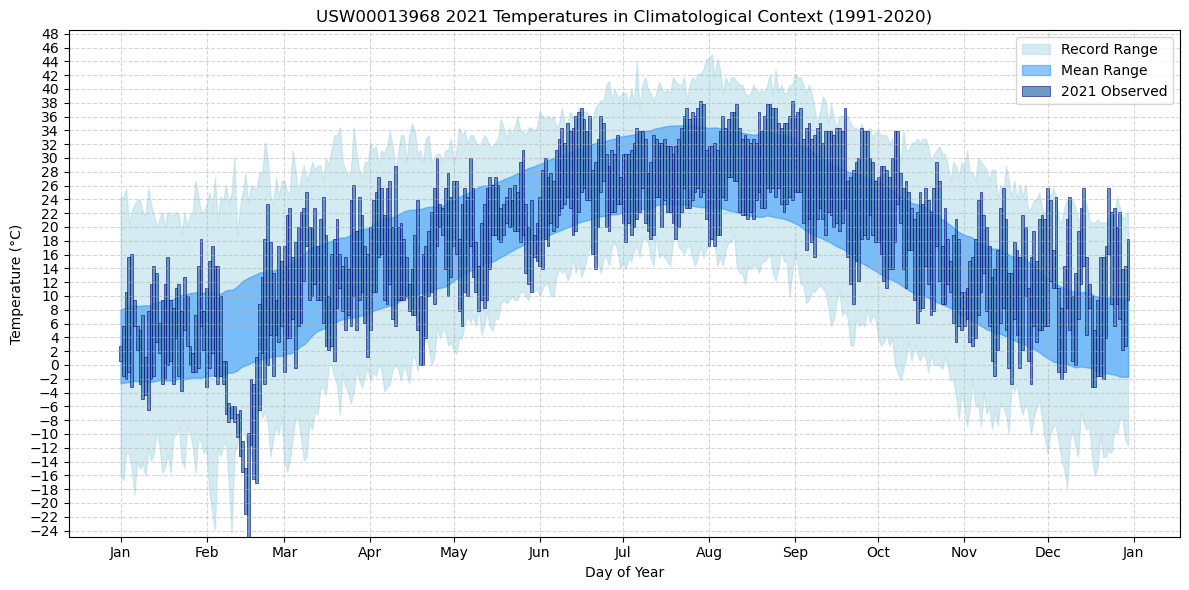

In [61]:
# Create plot consisting of 3 elements:
# 1) shaded area between record min and max temps using fill_between
# 2) shaded area between average min and max temps using fill_between
# 3) vertical bars for annual temps for a selected year (e.g. 2024) 

plt.figure(figsize=(12,6))

# First element:
plt.fill_between(merged_data['month_day'], merged_data['record_min_temp'], merged_data['record_max_temp'], color='lightblue', alpha=0.5, label='Record Range')

# Second element:
# smooth the average temp data using a rolling 14-day window
merged_data['avg_max_temp_smooth'] = merged_data['average_max_temp'].rolling(window=14, center=True, min_periods=1).mean()
merged_data['avg_min_temp_smooth'] = merged_data['average_min_temp'].rolling(window=14, center=True, min_periods=1).mean()
plt.fill_between(merged_data['month_day'], merged_data['avg_min_temp_smooth'], merged_data['avg_max_temp_smooth'], color='dodgerblue', alpha=0.5, label='Mean Range')

# Third element:
# plt.fill_between(merged_data['month_day'], merged_data['TMIN'], merged_data['TMAX'], color='midnightblue', alpha=0.5, label=f'{yr_annual} Observed Temperatures')

plt.bar(
    merged_data['month_day'], 
    merged_data['TMAX'] - merged_data['TMIN'], 
    bottom=merged_data['TMIN'], 
    width=1, 
    color='steelblue', 
    alpha=0.8,
    edgecolor='navy',      # dark border color
    linewidth=0.5,         # thin border 
    label=f'{yr_annual} Observed'
)

# Add a background grid with custom ticks to make it easier to interpret the graph
import matplotlib.dates as mdates
ax = plt.gca()
ax.yaxis.set_major_locator(plt.MultipleLocator(2))  # vertical grid every 2 degrees
ax.xaxis.set_major_locator(mdates.MonthLocator())    # horizontal grid every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # show month names
plt.grid(True, which='major', linestyle='--', alpha=0.5)

plt.xlabel('Day of Year')
plt.ylabel('Temperature (°C)')
plt.title(f'{stationID} {yr_annual} Temperatures in Climatological Context (1991-2020)')

plt.legend()
plt.tight_layout()

plt.savefig(f'{yr_annual}_annual_temperature_plot.png', dpi=300, bbox_inches='tight')

plt.show()